In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [34]:
data_in = np.load("Data/images.npy")
data_out = np.load("Data/labels.npy")

In [35]:
def convert_to_num(hour, minute):
    num = hour+minute/60
    return num

def group(num):
    array = np.zeros(48)
    category = num//0.25
    category = int(category)
    array[category]=1
    return array
    
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]



In [42]:
import keras_tuner
from tensorflow.keras import layers

hp = keras_tuner.HyperParameters()
def build_model_cnn(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5,7]),
        #activation function
        activation='relu',
        input_shape=[150,150,1],
        padding='same',)
    )
    model.add(
    layers.MaxPooling2D(pool_size = hp.Choice('pool_size', values = [2,3,4]),
    ),
    )
    # Tune the number of layers.
    for i in range(hp.Int("num_cnn_layers", 1, 5)):
        model.add(
            layers.Conv2D(
                #adding filter 
                filters=hp.Int(f'conv_{i}_filter', min_value=32, max_value=512, step=16),
                # adding kernel size
                kernel_size=hp.Choice(f'conv_{i}_kernel', values = [3,5]),
                #activation function
                activation='relu',
                padding='same'),
        )
        model.add(
            layers.MaxPooling2D(
                pool_size = 2
            ),
            )
                
    model.add(layers.Flatten())        

    for i in range(hp.Int("num_dense_layers", 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=60, max_value=515, step=20),
                activation=hp.Choice("activation", ["relu", "tanh"]),),
        )
        
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=hp.Choice(f'rate_{i}', values = [0.25,0.5,0.75])))
    
    model.add(layers.Dense(48, activation="softmax"))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

build_model_cnn(keras_tuner.HyperParameters())

In [47]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model_cnn,
    objective="val_accuracy",
    max_trials=30,
    num_initial_points=2,
    seed=90,
    directory="Task2",
    project_name="CNN",
    overwrite=True,
    #executions_per_trial,
)

In [38]:
data_in, data_out = unison_shuffled_copies(data_in, data_out)

In [39]:
class_out = []
for i in range(len(data_out)):
    hour = data_out[i][0]
    minute = data_out[i][1]
    hr_min_num = convert_to_num(hour, minute)
    hr_min_class = group(hr_min_num)
    class_out.append(hr_min_class)
class_out = np.array(class_out)

In [40]:
X_valid, X_train = data_in[15000:]/np.amax(data_in), data_in[:15000]/np.amax(data_in)
y_valid, y_train = class_out[15000:], class_out[:15000]

In [49]:
tuner.search(X_train, y_train, epochs=150, validation_data=(X_valid, y_valid), 
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)], batch_size=300)


Trial 30 Complete [00h 00m 30s]
val_accuracy: 0.023333333432674408

Best val_accuracy So Far: 0.6743333339691162
Total elapsed time: 08h 44m 19s
INFO:tensorflow:Oracle triggered exit


In [50]:
# Get the top 3 models.
models_cnn_class = tuner.get_best_models(num_models=3)
best_model_cnn_class = models_cnn_class[0]
# Build model
best_model_cnn_class.build(input_shape=(None, 28, 28))
best_model_cnn_class.summary()
tuner.results_summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 512)       147968    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 512)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        147488    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 32)       0

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, kernel_size=(5,5), activation='relu', input_shape=(150,150,1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
#model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Flatten())
#model.add(keras.layers.Dense(384, activation='relu'))
#model.add(keras.layers.Dense(384, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(24, activation='softmax'))

In [9]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.RMSprop(),
             metrics=['accuracy'])

In [10]:
history = model.fit(X_train, y_train, batch_size=100, epochs=30, verbose=1, 
                    validation_data=(X_valid, y_valid))

Epoch 1/50
150/150 [==============================] - 14s 63ms/step - loss: 3.4374 - accuracy: 0.0421 - val_loss: 3.1785 - val_accuracy: 0.0360
Epoch 2/50
150/150 [==============================] - 9s 59ms/step - loss: 3.1803 - accuracy: 0.0393 - val_loss: 3.1790 - val_accuracy: 0.0360
Epoch 3/50
150/150 [==============================] - 9s 59ms/step - loss: 3.1801 - accuracy: 0.0429 - val_loss: 3.1792 - val_accuracy: 0.0343
Epoch 4/50
150/150 [==============================] - 9s 58ms/step - loss: 3.1788 - accuracy: 0.0432 - val_loss: 3.1798 - val_accuracy: 0.0317
Epoch 5/50
150/150 [==============================] - 9s 58ms/step - loss: 3.1785 - accuracy: 0.0413 - val_loss: 3.1797 - val_accuracy: 0.0317
Epoch 6/50
150/150 [==============================] - 9s 58ms/step - loss: 3.1782 - accuracy: 0.0411 - val_loss: 3.1800 - val_accuracy: 0.0317
Epoch 7/50
150/150 [==============================] - 9s 57ms/step - loss: 3.1783 - accuracy: 0.0427 - val_loss: 3.1793 - val_accuracy: 0.041

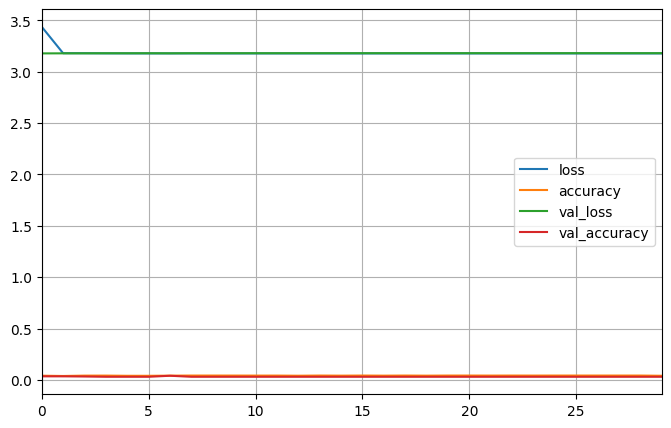

In [11]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
#plt.gca().set_ylim(0,1) # set the vertical range to [0-1]
plt.gca().set_xlim(0,29)
plt.show()